# IMPORTS

In [24]:
import sqlite3
import requests
import os
from spotify_preview import get_spotify_preview_url
import pandas as pd
import pickle
import numpy as np

# Read out data from Database

In [ ]:
import sqlite3
import requests
import os

# 1. Connect to selected Database
database_suffix = "PRODUCTION" # Can be: TEST or PRODUCTION
conn = sqlite3.connect(f"../data/spotify_scrape_{database_suffix}.db")
cursor = conn.cursor()

# 2. Query to get all unique track IDs alongside their first given genre by spotify
# Entries without a genre are excluded
query = """
    SELECT DISTINCT rp.track_id, rp.artist_id, ai.genres
    FROM recently_played rp
    JOIN artist_information ai ON rp.artist_id = ai.artist_id
    WHERE ai.genres IS NOT NULL AND ai.genres <> ''
"""
cursor.execute(query)

results = cursor.fetchall()

# Always good practice to close your DB connection
conn.close()

# Get Preview URL-s

In [2]:
# Get preview per track

from spotify_preview import get_spotify_preview_url
import pandas as pd

# 3. Build a list of dictionaries for valid tracks.
rows = []
for entry in results:
    track_id = entry[0]
    genre = entry[2]
    preview_url = get_spotify_preview_url(track_id)
    if preview_url:
        rows.append({
            'id': track_id,
            'genre': genre,
            'preview': preview_url
        })
    else:
        print(f"Preview URL not found for track ID: {track_id}")

# Create a DataFrame from the collected rows.
tracks_info_df = pd.DataFrame(rows)


Preview URL not found for track ID: 78UHoW9y3mgbl2ngIWrx0w
Preview URL not found for track ID: 3Umu0eIBBe3tXSqBmdMvpo
Preview URL not found for track ID: 16PmqImOpc0RIiYuhwiIjx
Preview URL not found for track ID: 4TxfZzrq0dH2Wmfl4dAjN9
Preview URL not found for track ID: 5xy9sJQW5kJ18XW4XbNHme
Preview URL not found for track ID: 2a9oLGGecoIRReHl6HQ79s
Preview URL not found for track ID: 6L1e0NXv19D2bz1kAeaIR0
Preview URL not found for track ID: 5Zi5RHFI0tWKkzoiob2OtU
Preview URL not found for track ID: 2DQdBq3FmZUiT63yaYaXV6
Preview URL not found for track ID: 0lnX43Ds6EbnF6HwCdfztJ
Preview URL not found for track ID: 4nl8dfUUTvIaiJEdpedPnI
Preview URL not found for track ID: 4iClmNkNhf49saCho7AhqC
Preview URL not found for track ID: 74VihilooGca7LtjxihEu6
Preview URL not found for track ID: 775e6dy2iuPc9AhqfFRHqX
Preview URL not found for track ID: 19ceLSHTJq1TDOfmpuJdNE
Preview URL not found for track ID: 1LQJjfiFaNBr9j42TGvxvk
Preview URL not found for track ID: 6r0Nrpb5ECo71iVRCsTB

'\nfor entry in results:\n    entry = entry[0]\n    preview_url = get_spotify_preview_url(entry)\n    if preview_url:\n        track_preview_dict[entry] = preview_url\n    else:\n        print(f"Preview URL not found for track ID: {entry}")'

# Save and Read File

In [3]:
# Export to CSV (without the index)
tracks_info_df.to_csv('data.csv', index=False)

In [25]:
# Read CSV File if neccecary
tracks_info_df = pd.read_csv('data.csv')

In [60]:
unique_values = tracks_info_df["genre"].drop_duplicates().tolist()


# Download all preview mp3 files

In [ ]:

# 3. Prepare a local folder to hold audio previews
download_folder = "audio_previews"
os.makedirs(download_folder, exist_ok=True)

# 4. Iterate through the track list
for idx, row in tracks_info_df.iterrows():

    track_id = row['id']
    preview_url = row['preview']

    # Form the output filename for the preview
    output_filename = os.path.join(download_folder, f"{track_id}.mp3")
    
    # Skip if the file already exists
    if os.path.exists(output_filename):
        print(f"Preview for track {track_id} already exists. Skipping...")
        continue

    # Download the preview
    try:
        response = requests.get(preview_url, timeout=30)  # you can adjust timeout
        if response.status_code == 200:
            with open(output_filename, "wb") as f:
                f.write(response.content)
            print(f"Downloaded preview for track {track_id}")
        else:
            print(f"Failed to download track {track_id}: HTTP {response.status_code}")
    except Exception as e:
        print(f"Error downloading track {track_id}: {e}")


NameError: name 'os' is not defined

# Extract Track Features

In [5]:
import os
import pickle
import shutil
import librosa
import numpy as np
from sklearn.preprocessing import LabelEncoder


def summarize_feature(feature_array):
    """
    feature_array shape: [num_coeffs, num_frames]
    Returns: 1D numpy array containing mean, std, and median of each row.
    """
    # axis=1 means we compute statistics across 'frames'
    means = np.mean(feature_array, axis=1)
    stds = np.std(feature_array, axis=1)
    medians = np.median(feature_array, axis=1)
    
    # Concatenate all stats into one 1D array
    return np.concatenate([means, stds, medians], axis=0)  #[means, stds, medians]

def extract_features_librosa(file_path):

    # Load the audio file
    y, sr = librosa.load(file_path, sr=None)
    
    # Extract features
    chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
    chroma_cqt = librosa.feature.chroma_cqt(y=y, sr=sr)
    chroma_cens = librosa.feature.chroma_cens(y=y, sr=sr)
    chroma_vqt = librosa.feature.chroma_vqt(y=y, sr=sr, intervals='equal')
    melspectogram = librosa.feature.melspectrogram(y=y, sr=sr)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=12) # Numer of mfccs difference?
    rms = librosa.feature.rms(y=y)
    spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
    spectral_bandwith = librosa.feature.spectral_bandwidth(y=y, sr=sr)
    spectral_contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
    spectral_flatness = librosa.feature.spectral_flatness(y=y) 
    spectral_rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
    poly_features = librosa.feature.poly_features(y=y, sr=sr)
    tonnetz = librosa.feature.tonnetz(y=y, sr=sr)
    zero_crossings = librosa.feature.zero_crossing_rate(y)
    
    # Estimate tempo and beats
    tempo = librosa.feature.tempo(y=y, sr=sr)
    tempogram = librosa.feature.tempogram(y=y, sr=sr)
    fourier_tempogram = librosa.feature.fourier_tempogram(y=y, sr=sr)
    tempogram_ratio = librosa.feature.tempogram_ratio(y=y, sr=sr)

    track_features = [
        summarize_feature(mfccs),
        summarize_feature(chroma_stft),
        summarize_feature(chroma_cqt),
        summarize_feature(chroma_cens),
        summarize_feature(chroma_vqt),
        summarize_feature(melspectogram),
        summarize_feature(spectral_centroid),
        summarize_feature(spectral_bandwith),
        summarize_feature(spectral_contrast),
        summarize_feature(spectral_flatness),
        summarize_feature(spectral_rolloff),
        summarize_feature(poly_features),
        summarize_feature(tonnetz),
        summarize_feature(zero_crossings),
        summarize_feature(tempogram),
        summarize_feature(fourier_tempogram),
        summarize_feature(tempogram_ratio),
        summarize_feature(rms),
        np.ravel(tempo) # Flatten Tempo into an 1D array
    ]

    return track_features


folder_path = './audio_previews'
results_file = 'audio_features.pkl'

# Check if the features pickle file exists, if yes load it
if os.path.exists(results_file):
    with open(results_file, 'rb') as file:
        saved_data = pickle.load(file)
    X = saved_data.get('X', [])
    y_labels = saved_data.get('y_labels', [])
    processed_files = set(saved_data.get('processed_files', []))
    print(f"Loaded {len(processed_files)} processed tracks")
else:
    X = []
    y_labels = []
    processed_files = set()

all_files = [file for file in os.listdir(folder_path) if file.endswith('.mp3')]
total_files_count = len(all_files)
counter = 0

for file in all_files:

    if file in processed_files:
        counter += 1
        continue

    counter += 1
    print(f'Processing file {counter}/{total_files_count}...')

    file_path = os.path.join(folder_path, file)
    file_id = os.path.splitext(file)[0]

    features = extract_features_librosa(file_path)
    features_vector = np.concatenate([np.ravel(feat) for feat in features])
    X.append(features_vector)

    try:
        genre = tracks_info_df.loc[tracks_info_df['id'] == file_id, 'genre'].iloc[0]
        y_labels.append(genre)
    except IndexError:
        print("This should actually not happen :(, couldnt find genre in the pandas dataframe based on ID")
        y_labels.append(None)
    
    processed_files.add(file)

    with open(results_file, 'wb') as file:
        pickle.dump({
            'X': X,
            'y_labels': y_labels,
            'processed_files': list(processed_files)
        }, file)

    if counter % 10 == 0:
        base, ext = os.path.splitext(results_file)
        backup_file = f"{base}_backup{ext}"

        shutil.copy(results_file, backup_file)

Loaded 13309 processed tracks


# Read processed tracks file

In [26]:

results_file = 'audio_features.pkl'

# Check if the features pickle file exists, if yes load it
if os.path.exists(results_file):
    with open(results_file, 'rb') as file:
        saved_data = pickle.load(file)
    X = saved_data.get('X', [])
    y_labels = saved_data.get('y_labels', [])
    processed_files = set(saved_data.get('processed_files', []))
    print(f"Loaded {len(processed_files)} processed tracks")

Loaded 13309 processed tracks


# Preprocessing

In [27]:
# --- Turn X into an np array ---

X = np.array(X)
print("shape of feature matrix X: ", X.shape)

shape of feature matrix X:  (13309, 2398)


In [ ]:
# --- Replacing Sub-genres with the genres ---

genre_mapping = {
    'lo-fi beats': 'lo-fi',
    'chillwave': 'lo-fi',

    'nu metal': 'metal',

    'hypertechno': 'techno',

    'acid house': 'acid',
    'acid techno': 'acid',

    'afrobeat': 'afro',
    'afropop': 'afro',

    'art rock': 'rock',

    'britpop': 'alternative rock',
    
    'art pop': 'pop',
    'acoustic pop': 'pop',
    'bedroom pop': 'pop',

    'alt country': 'country',

    'bass house': 'alternative house',

    'blues rock': 'blues',

    'brooklyn drill': 'drill'
    
} 

# remove: adult standards, americana?, anime?, baroque pop, bebop, big band, big beat, big room, bluegrass
# boom bap, bossa nova brazilian bass breakbeat breakcore 'calypso' 'canzone napoletana'
# 'celtic rock' 'chamber pop' 'chicha' "children's music"

y_labels_normalized = [genre_mapping.get(label, label) for label in y_labels]


In [29]:
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.preprocessing import LabelEncoder


# --- Encoding the Genre Labels ---

le = LabelEncoder()
y = le.fit_transform(y_labels_normalized)
print("Unique genres: ", le.classes_)
print("Shape of label array y: ", y.shape)




Unique genres:  ['acid' 'acid jazz' 'acoustic rock' 'adult standards' 'afro' 'afro house'
 'afrobeats' 'album rock' 'alternative dance' 'alternative hip hop'
 'alternative house' 'alternative metal' 'alternative r&b'
 'alternative rock' 'ambient' 'americana' 'anime' 'arena rock'
 'aussie drill' 'avant-garde' 'azonto' 'ballroom vogue' 'banda'
 'baroque pop' 'bassline' 'bebop' 'bhangra' 'big band' 'big beat'
 'big room' 'black metal' 'bluegrass' 'blues' 'bolero' 'bollywood'
 'boom bap' 'bossa nova' 'brazilian bass' 'brazilian jazz'
 'brazilian phonk' 'breakbeat' 'breakcore' 'c-pop' 'calypso'
 'canzone napoletana' 'ccm' 'celtic' 'celtic rock' 'chamber pop'
 'champeta' 'chanson' 'chicago house' 'chicha' "children's music"
 'chinese hip hop' 'choral' 'christian country' 'christian hip hop'
 'christian rock' 'christmas' 'city pop' 'classic rock' 'classical'
 'classical piano' 'cloud rap' 'cold wave' 'colombian pop' 'comedy'
 'cool jazz' 'corrido' 'corridos tumbados' 'country' 'country rock'


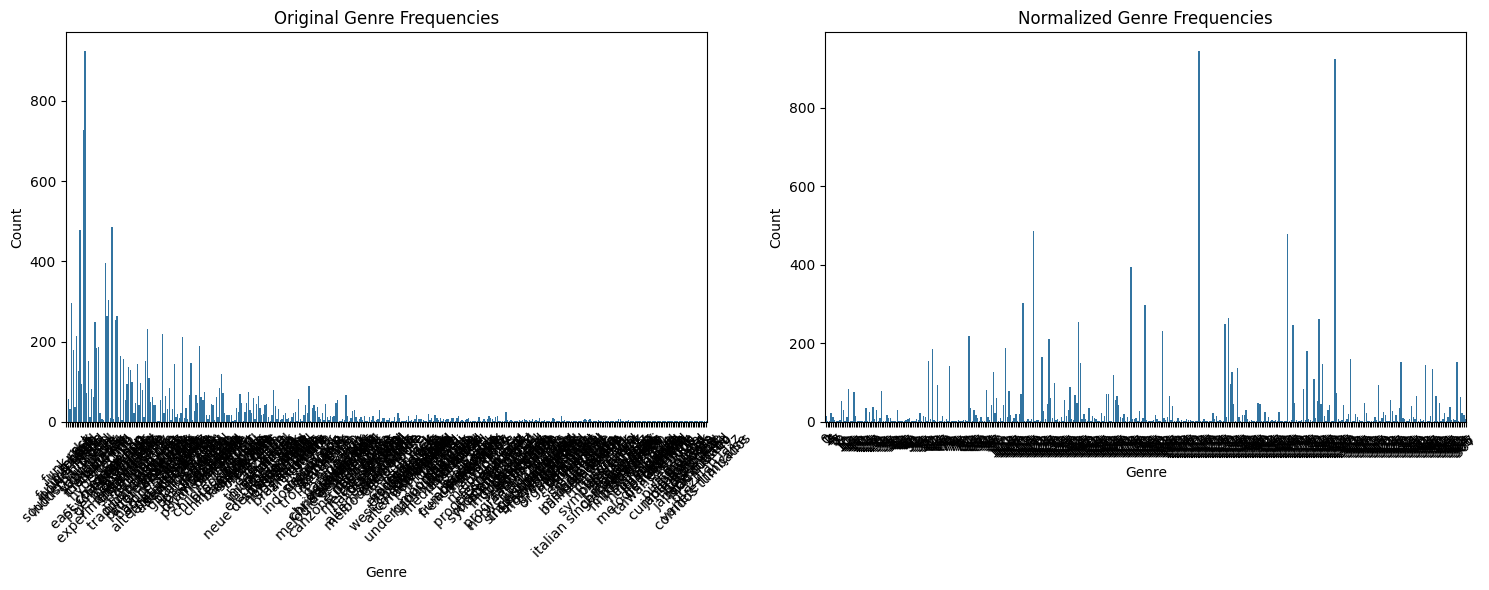

In [30]:
# -- Count and show the genres ---

freq_original = Counter(y_labels)
freq_normalized = Counter(y)

# Create data for plotting.
orig_genres = list(freq_original.keys())
orig_counts = list(freq_original.values())

norm_genres = list(freq_normalized.keys())
norm_counts = list(freq_normalized.values())

# Create subplots: one for original frequencies and one for normalized.
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# Plot original label frequencies.
sns.barplot(x=orig_genres, y=orig_counts, ax=axs[0])
axs[0].set_title("Original Genre Frequencies")
axs[0].set_xlabel("Genre")
axs[0].set_ylabel("Count")
axs[0].tick_params(axis='x', rotation=45)

# Plot normalized label frequencies.
sns.barplot(x=norm_genres, y=norm_counts, ax=axs[1])
axs[1].set_title("Normalized Genre Frequencies")
axs[1].set_xlabel("Genre")
axs[1].set_ylabel("Count")
axs[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

Class counts: Counter({np.int64(214): 945, np.int64(292): 925, np.int64(119): 485, np.int64(265): 479, np.int64(175): 395, np.int64(113): 303, np.int64(183): 297, np.int64(231): 264, np.int64(283): 263, np.int64(145): 254, np.int64(229): 248, np.int64(268): 246, np.int64(193): 232, np.int64(82): 219, np.int64(128): 211, np.int64(103): 187, np.int64(61): 185, np.int64(276): 180, np.int64(124): 165, np.int64(301): 161, np.int64(59): 156, np.int64(330): 152, np.int64(362): 152, np.int64(146): 151, np.int64(285): 146, np.int64(344): 144, np.int64(71): 141, np.int64(236): 137, np.int64(348): 135, np.int64(96): 128, np.int64(233): 126, np.int64(165): 120, np.int64(280): 108, np.int64(131): 98, np.int64(232): 97, np.int64(317): 94, np.int64(64): 94, np.int64(140): 88, np.int64(13): 83, np.int64(274): 83, np.int64(92): 80, np.int64(105): 79, np.int64(32): 78, np.int64(16): 75, np.int64(293): 74, np.int64(112): 72, np.int64(162): 71, np.int64(161): 70, np.int64(143): 67, np.int64(167): 66, np.i

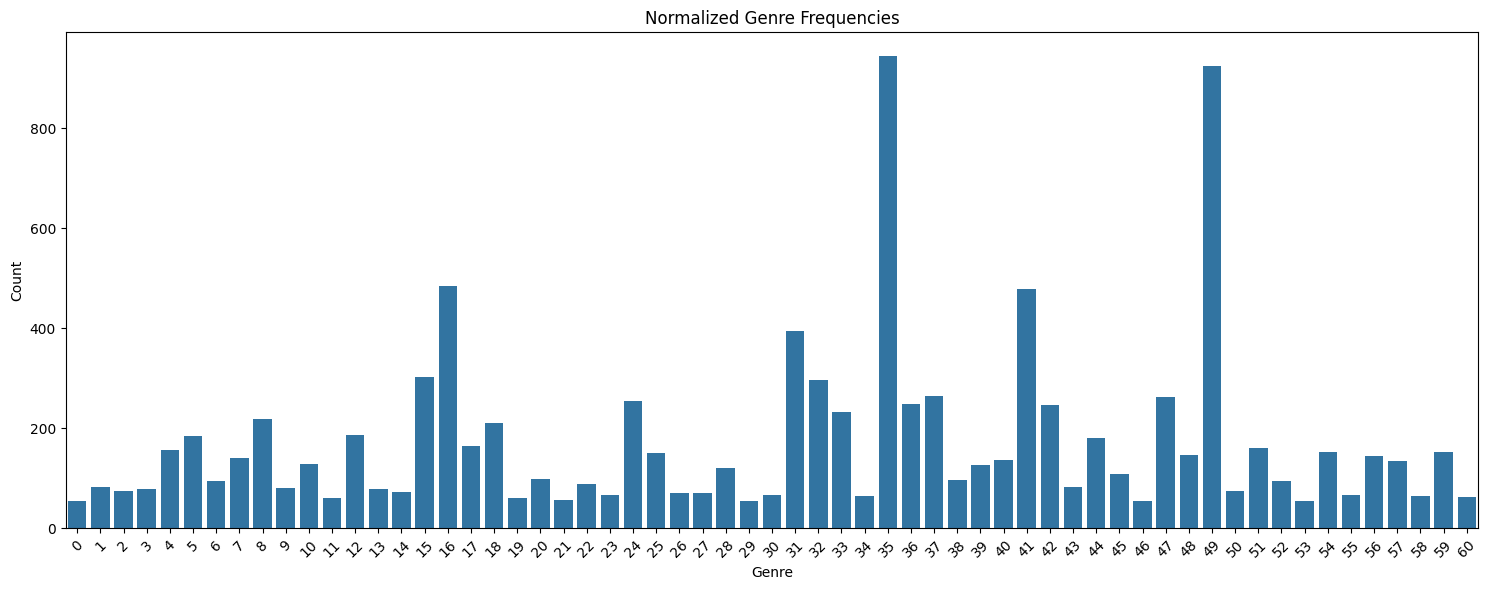

In [31]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np
from collections import Counter


if np.iscomplexobj(X):
    X = np.abs(X)

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Check class counts.
counter = Counter(y)
print("Class counts:", counter)

# Keep only classes with at least 2 samples.
classes_to_keep = {cls for cls, count in counter.items() if count >= 50}
indices_to_keep = [i for i, label in enumerate(y) if label in classes_to_keep]

# Filter your data.
X_filtered = X_scaled[indices_to_keep]
y_filtered = y[indices_to_keep]

le = LabelEncoder()
y_encoded = le.fit_transform(y_filtered)

freq_leftover = Counter(y_encoded)
leftover_genres = list(freq_leftover.keys())
leftover_counts = list(freq_leftover.values())

fig, axs = plt.subplots(figsize=(15, 6))

# Plot normalized label frequencies.
sns.barplot(x=leftover_genres, y=leftover_counts, ax=axs)
axs.set_title("Normalized Genre Frequencies")
axs.set_xlabel("Genre")
axs.set_ylabel("Count")
axs.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()



In [32]:
# Split the standardized features and labels into training and test sets.
# Here, 20% of the data is reserved for testing.
X_train, X_test, y_train, y_test = train_test_split(
    X_filtered, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

print("Training set shape:", X_train.shape, y_train.shape)
print("Test set shape:", X_test.shape, y_test.shape)

Training set shape: (8369, 2398) (8369,)
Test set shape: (2093, 2398) (2093,)


# Some Basic ML Modells

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

# --- Logistic Regression ---
lr = LogisticRegression(max_iter=1000, random_state=42)
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr))

# --- Random Forest Classifier ---
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))

# --- Support Vector Machine (SVM) ---
svc = SVC(kernel='rbf', random_state=42)
svc.fit(X_train, y_train)
y_pred_svc = svc.predict(X_test)
print("SVM Accuracy:", accuracy_score(y_test, y_pred_svc))
print(classification_report(y_test, y_pred_svc))

Logistic Regression Accuracy: 0.6184834123222749
              precision    recall  f1-score   support

           0       0.70      0.61      0.66        31
           1       0.47      0.46      0.47        37
           2       0.30      0.29      0.29        28
           3       0.38      0.34      0.36        44
           4       0.31      0.19      0.24        26
           5       0.62      0.54      0.58        37
           6       0.48      0.54      0.51        61
           7       0.65      0.66      0.66        97
           8       0.84      0.79      0.81        33
           9       0.57      0.55      0.56        42
          10       0.44      0.51      0.47        51
          11       0.42      0.33      0.37        30
          12       0.85      0.92      0.88        24
          13       0.56      0.57      0.57        79
          14       0.73      0.76      0.74        59
          15       0.79      0.98      0.87        46
          16       0.86      0.8

# Sequential ANN

In [37]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
import tensorflow as tf

# For reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Assuming X_train, X_test, y_train, y_test are already defined.
# Also assume that y are integer-encoded class labels.

num_features = X_train.shape[1]
num_classes = len(np.unique(y_train))

# Build a simple feedforward neural network.
model = Sequential([
    Dense(64, activation='relu', input_dim=num_features, kernel_regularizer=regularizers.l2(0.001)), 
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Use early stopping to prevent overfitting.
#early_stop = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

# Train the model.
history = model.fit(X_train, y_train, epochs=100, batch_size=64,
                    validation_split=0.2)

# Evaluate on the test set.
test_loss, test_acc = model.evaluate(X_test, y_test)
print("Test Accuracy:", test_acc)

Epoch 1/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.1095 - loss: 4.1205 - val_accuracy: 0.2879 - val_loss: 3.1573
Epoch 2/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2390 - loss: 3.3288 - val_accuracy: 0.3244 - val_loss: 2.8534
Epoch 3/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2716 - loss: 3.0417 - val_accuracy: 0.3608 - val_loss: 2.6433
Epoch 4/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3139 - loss: 2.8165 - val_accuracy: 0.3722 - val_loss: 2.5063
Epoch 5/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3414 - loss: 2.6595 - val_accuracy: 0.3853 - val_loss: 2.4230
Epoch 6/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3608 - loss: 2.5447 - val_accuracy: 0.4020 - val_loss: 2.3487
Epoch 7/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3985 - loss: 2.3876 - val_accuracy: 0.4403 - val_loss: 2.2768
Epoch 8/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3964 - loss: 2.3489 - val_accu

In [34]:
import keras_tuner as kt
from tensorflow.keras import layers, models
import tensorflow as tf

def build_model(hp):
    model = models.Sequential()
    
    # Let the tuner pick from a few common activation functions
    activation_1 = hp.Choice('activation_1', values=['relu', 'tanh', 'sigmoid'])
    units_1 = hp.Int('units_1', min_value=32, max_value=256, step=32)
    model.add(layers.Dense(units_1, activation=activation_1, input_shape=(X_train.shape[1],)))
    
    # Similarly, you could do a second layer with a different choice
    activation_2 = hp.Choice('activation_2', values=['relu', 'tanh', 'sigmoid'])
    units_2 = hp.Int('units_2', min_value=32, max_value=256, step=32)
    model.add(layers.Dense(units_2, activation=activation_2))
    
    # Output layer
    model.add(layers.Dense(num_classes, activation='softmax'))
    
    # Hyperparameter for learning rate
    lr = hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')
    
    # Compile the model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=1,
    overwrite=True,
    directory='my_dir',
    project_name='activation_tuning'
)

# Start the search
tuner.search(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=10
)

# Retrieve best model & hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = tuner.hypermodel.build(best_hps)
best_model.summary()

model = best_model



NameError: name 'num_classes' is not defined

# KNN Model

Best parameters found: {'n_neighbors': 7, 'weights': 'distance'}
Accuracy: 0.42857142857142855
Classification Report:
               precision    recall  f1-score   support

           0       0.20      0.18      0.19        11
           1       0.23      0.29      0.26        17
           2       0.00      0.00      0.00        15
           3       0.27      0.25      0.26        16
           4       0.27      0.68      0.38        31
           5       0.22      0.24      0.23        37
           6       0.31      0.21      0.25        19
           7       0.32      0.29      0.30        28
           8       0.33      0.18      0.24        44
           9       0.54      0.44      0.48        16
          10       0.50      0.35      0.41        26
          11       0.75      0.50      0.60        12
          12       0.41      0.38      0.39        37
          13       0.14      0.06      0.09        16
          14       0.00      0.00      0.00        14
          15    

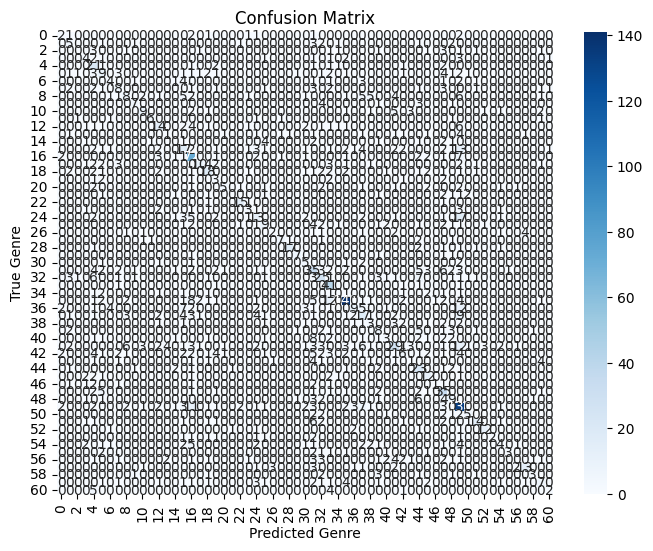

In [38]:
# Import necessary modules
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import confusion_matrix, classification_report

param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25],
    'weights': ['uniform', 'distance']
}

# Initialize the KNN model (you can adjust n_neighbors as needed)
knn = KNeighborsClassifier()

grid_search = GridSearchCV(knn, param_grid, cv=5)
grid_search.fit(X_train, y_train)
print("Best parameters found:", grid_search.best_params_)

best_knn = grid_search.best_estimator_

# Predict genres for the test data
y_pred = best_knn.predict(X_test)

# Evaluate the model's performance
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Plot the confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Genre')
plt.xlabel('Predicted Genre')
plt.show()

66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 686us/step


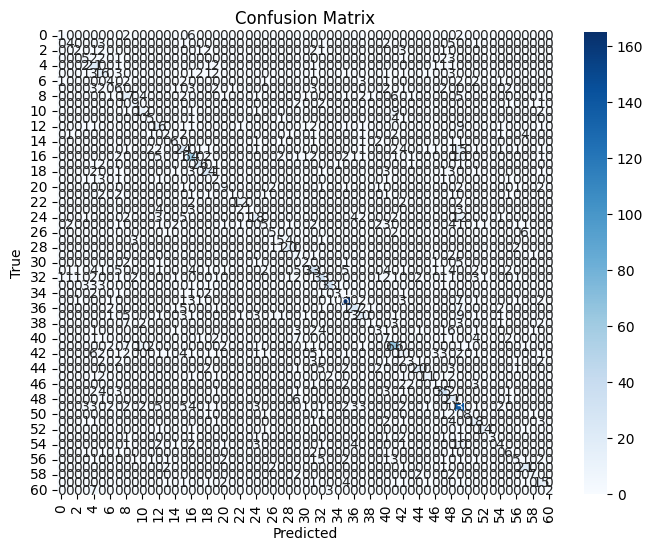

              precision    recall  f1-score   support

           0       0.33      0.09      0.14        11
           1       0.44      0.24      0.31        17
           2       0.40      0.13      0.20        15
           3       0.26      0.31      0.29        16
           4       0.30      0.68      0.42        31
           5       0.33      0.43      0.37        37
           6       0.31      0.21      0.25        19
           7       0.19      0.21      0.20        28
           8       0.33      0.39      0.35        44
           9       0.60      0.56      0.58        16
          10       0.40      0.46      0.43        26
          11       0.45      0.42      0.43        12
          12       0.36      0.43      0.40        37
          13       0.25      0.12      0.17        16
          14       0.43      0.43      0.43        14
          15       0.41      0.39      0.40        61
          16       0.60      0.66      0.63        97
          17       0.81    

In [40]:

#Confusion Matrix
# Get predictions on the test set.
y_pred = np.argmax(model.predict(X_test), axis=1)

# Create confusion matrix.
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Optionally, print a detailed classification report.
print(classification_report(y_test, y_pred))


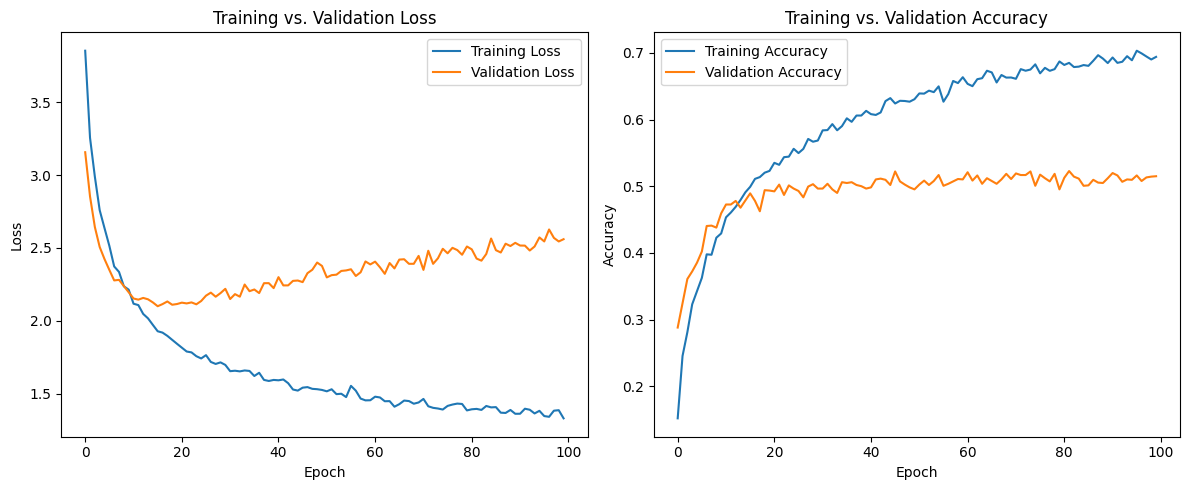

In [41]:
# Plot training vs. validation loss and accuracy.
plt.figure(figsize=(12,5))

# Loss Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs. Validation Loss')
plt.legend()

# Accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs. Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


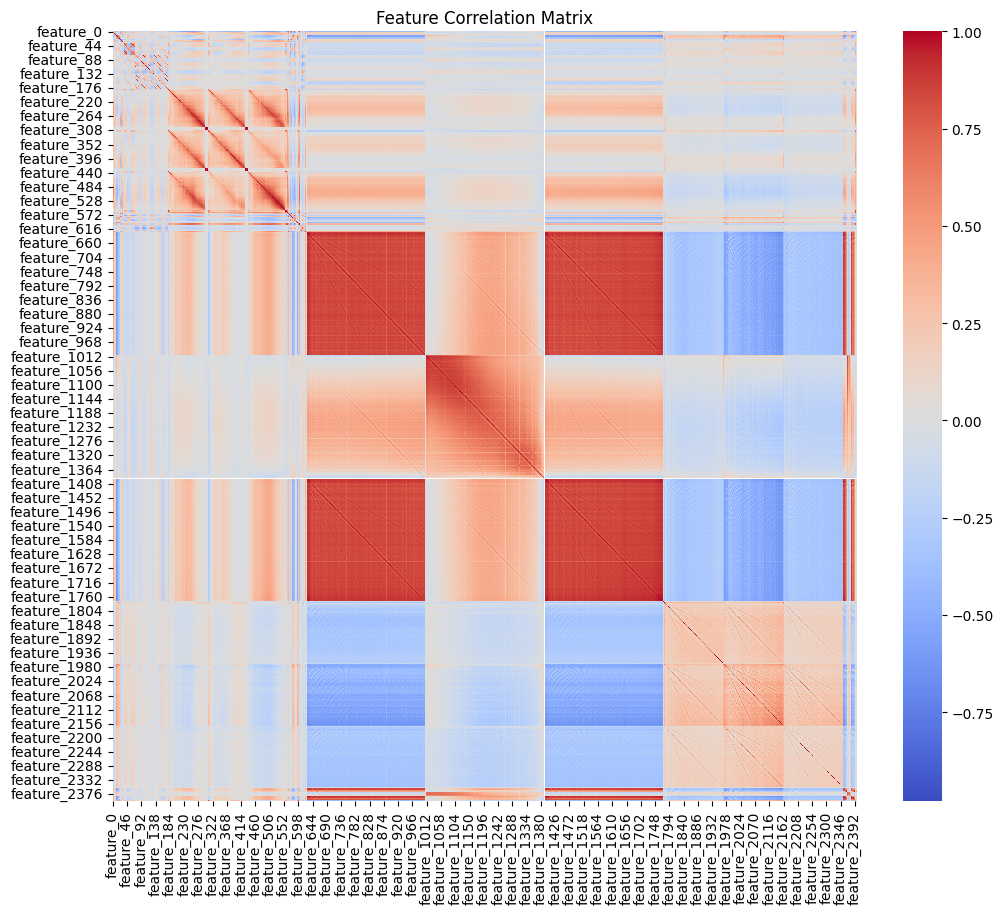

In [16]:
# Create a DataFrame for features. If X has many features, consider selecting a subset.
df_features = pd.DataFrame(X, columns=[f'feature_{i}' for i in range(X.shape[1])])

# Compute the correlation matrix.
corr = df_features.corr()

plt.figure(figsize=(12,10))
sns.heatmap(corr, cmap='coolwarm', annot=False)
plt.title('Feature Correlation Matrix')
plt.show()


In [76]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.inspection import permutation_importance

# Wrapper for the Keras model to work with sklearn's permutation_importance.
class KerasClassifierWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, model):
        self.model = model
        
    def fit(self, X, y):
        # Model is already trained.
        return self
    
    def predict(self, X):
        preds = self.model.predict(X)
        return np.argmax(preds, axis=1)
    
    def score(self, X, y):
        y_pred = self.predict(X)
        return np.mean(y_pred == y)

# Wrap our trained model.
wrapper = KerasClassifierWrapper(model)

# Compute permutation importance on the test set.
result = permutation_importance(wrapper, X_test, y_test, n_repeats=10,
                                random_state=42, scoring='accuracy')
importance_means = result.importances_mean

# Plot the permutation importance.
plt.figure(figsize=(12, 6))
features = [f'feature_{i}' for i in range(X.shape[1])]
plt.bar(features, importance_means)
plt.xticks(rotation=90)
plt.xlabel('Feature')
plt.ylabel('Mean Importance')
plt.title('Permutation Feature Importance')
plt.show()


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


KeyboardInterrupt: 